In [ ]:
import pandas as pd
import numpy as np
import os 
import sys

In [25]:
#impute data
from scipy import stats
df = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/Area_1_2024_11_04_23_46_26_pos.csv")
df['chem_id'] = (
                np.round(df['Average Mz'], 3).astype(str) + '_@_' 
                + np.round(df['Average Rt(min)'], 3).astype(str)
                )

loc1a = df['chem_id']
loc1b = df.loc[:, 'Alignment ID':'MS/MS spectrum']
loc1 = pd.concat([loc1a, loc1b], axis=1)
loc1 = loc1.set_index('chem_id')

loc2a = df.loc[:, 'BH04254 _r1_b1':'QC2-B3-pos_r2_b3']
loc3 = pd.concat([loc1a, loc2a], axis=1)
loc3 = loc3.set_index('chem_id')
loc3[loc3 < 5000] = np.nan

loc3['count'] = loc3.count(axis = 1)
loc3['freq'] = loc3['count']/len(loc3.columns)
loc3['freq%'] = loc3['freq']*100
loc3 = loc3[loc3['freq%'] > 70]
loc3 = loc3.loc[:,  loc3.columns.str.contains('BH')]

loc3L = np.log10(loc3)

def fillNaN_with_unifrand(df):
    lower, upper = 0, df.min()
    a = df.values
    m = np.isnan(a) # mask of NaNs
    mu, sigma = df.min(), df.std()
    a[m] = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=m.sum())
    return df


loc3Lmod = loc3L.apply(fillNaN_with_unifrand)
loc3Lmod = 10**loc3Lmod

loc1 = loc1.reset_index()
loc3Lmod = loc3Lmod.reset_index()
df = pd.merge(loc1, loc3Lmod, how='inner')
df = df.set_index('chem_id')
# df.to_csv('Pos_Clean.csv')

C:\Users\yangj\AppData\Local\Temp\ipykernel_60676\3116443079.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loc3['count'] = loc3.count(axis = 1)
C:\Users\yangj\AppData\Local\Temp\ipykernel_60676\3116443079.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loc3['freq'] = loc3['count']/len(loc3.columns)
C:\Users\yangj\AppData\Local\Temp\ipykernel_60676\3116443079.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [26]:
# df1 = pd.read_csv('Pos_Clean.csv')
# df1 = df1.set_index('chem_id')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df1 = df.copy()
loc1 = df1.loc[:, 'Alignment ID':'MS/MS spectrum']
loc2 = df1.loc[:, df1.columns.str.contains('BH')]

df2 = pd.read_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/sample_meta2.csv')
df2 = df2[df2['Sample Name'].isin(loc2.columns)]
df2 = df2.set_index('Sample Name')

loc2 = loc2.loc[:, loc2.columns.isin(df2.index)]
loc2 = np.log10(loc2)

# Assuming 'Batch' column indicates the batch, and rest are features
batches = df2['batch']
data = loc2.T

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Perform PCA to identify batch-related variance
pca = PCA(n_components=10)  # Adjust components as necessary
pca_data = pca.fit_transform(scaled_data)

# Identify components correlated with batch
batch_effects = []
for i in range(pca_data.shape[1]):
    correlation = np.corrcoef(pca_data[:, i], batches)[0, 1]
    if abs(correlation) > 0.1:  # Threshold can be adjusted
        batch_effects.append(i)

# Remove batch effects by subtracting batch-correlated components
pca_data[:, batch_effects] = 0

# Reconstruct the data without batch effects
corrected_data = pca.inverse_transform(pca_data)
corrected_data = scaler.inverse_transform(corrected_data)
corrected_data = 10**(corrected_data)

# Save corrected dataset
corrected_df = pd.DataFrame(corrected_data, columns=data.columns)
corrected_df = corrected_df.T
corrected_df.columns = loc2.columns
# corrected_df = pd.concat([loc1, corrected_df], axis=1)
corrected_df.to_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/Pos_PCA_batchcorrected_data.csv')

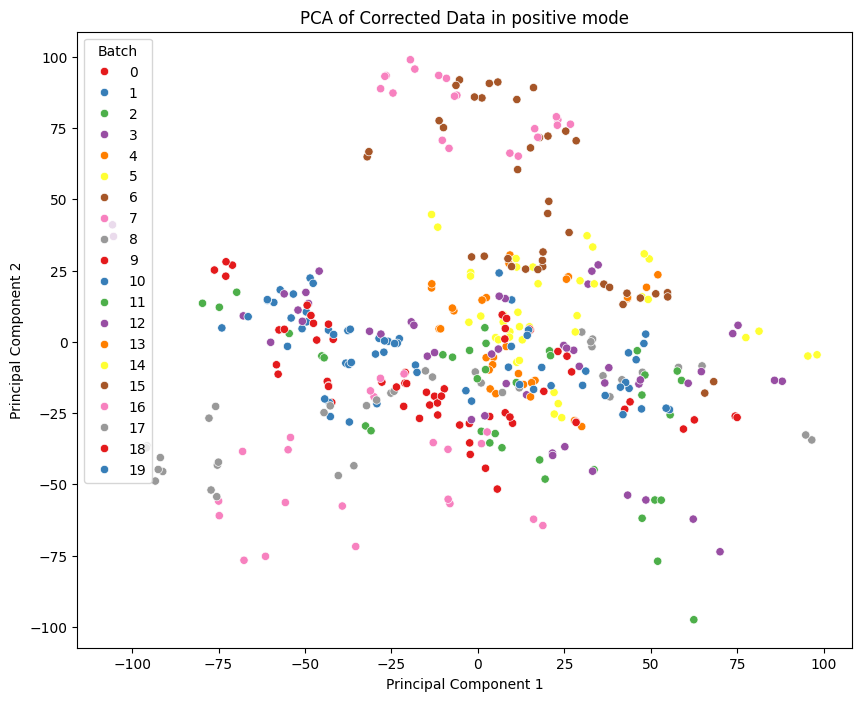

In [16]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

PCA = PCA(n_components=2)
corrected_df = np.log10(corrected_df)
X = corrected_df.T
X = StandardScaler().fit_transform(X)
pca_result = PCA.fit_transform(X)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Sample'] = df2.index
pca_df['Batch'] = df2['batch'].values
pca_df['Batch'] = pca_df['Batch'].astype('category')
pca_df['Sample'] = pca_df['Sample'].astype('category')
pca_df['Batch'] = pca_df['Batch'].cat.codes
pca_df['Sample'] = pca_df['Sample'].cat.codes

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Batch', palette='Set1')
plt.title('PCA of Corrected Data in positive mode')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Batch')
# plt.savefig('PCA_corrected_data.png', dpi=300)
plt.show()

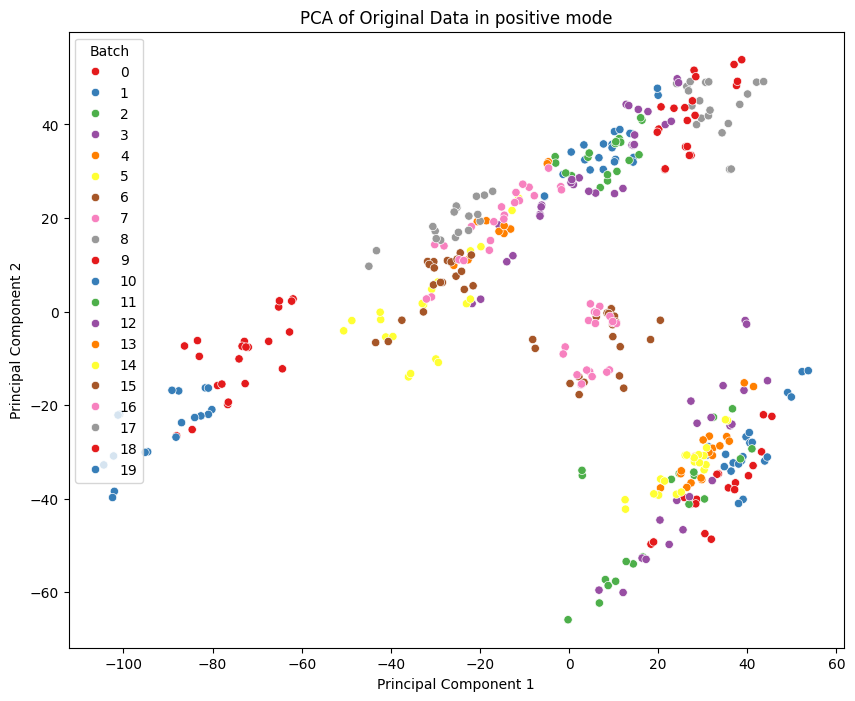

In [17]:
# orignial peak area for PCA 
rawpeak2 = loc2.copy()
# PCA analysis and plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
PCA = PCA(n_components=2)
X = rawpeak2.T
X = StandardScaler().fit_transform(X)
pca_result = PCA.fit_transform(X)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Sample'] = df2.index
pca_df['Batch'] = df2['batch'].values
pca_df['Batch'] = pca_df['Batch'].astype('category')
pca_df['Sample'] = pca_df['Sample'].astype('category')
pca_df['Batch'] = pca_df['Batch'].cat.codes
pca_df['Sample'] = pca_df['Sample'].cat.codes
# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Batch', palette='Set1')
plt.title('PCA of Original Data in positive mode')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Batch')
# plt.savefig('PCA_original_data.png', dpi=300)
plt.show()

In [27]:
#impute data
from scipy import stats
df = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Area_1_2024_11_04_16_24_07_neg.csv")
df['chem_id'] = (
                np.round(df['Average Mz'], 3).astype(str) + '_@_' 
                + np.round(df['Average Rt(min)'], 3).astype(str)
                )

loc1a = df['chem_id']
loc1b = df.loc[:, 'Alignment ID':'MS/MS spectrum']
loc1 = pd.concat([loc1a, loc1b], axis=1)
loc1 = loc1.set_index('chem_id')

loc2a = df.loc[:, 'BH04254_r_B1':'QC2-neg_r2_B3']
loc3 = pd.concat([loc1a, loc2a], axis=1)
loc3 = loc3.set_index('chem_id')
loc3[loc3 < 5000] = np.nan

loc3['count'] = loc3.count(axis = 1)
loc3['freq'] = loc3['count']/len(loc3.columns)
loc3['freq%'] = loc3['freq']*100
loc3 = loc3[loc3['freq%'] > 70]
loc3 = loc3.loc[:,  loc3.columns.str.contains('BH')]

loc3L = np.log10(loc3)

def fillNaN_with_unifrand(df):
    lower, upper = 0, df.min()
    a = df.values
    m = np.isnan(a) # mask of NaNs
    mu, sigma = df.min(), df.std()
    a[m] = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=m.sum())
    return df


loc3Lmod = loc3L.apply(fillNaN_with_unifrand)
loc3Lmod = 10**loc3Lmod

loc1 = loc1.reset_index()
loc3Lmod = loc3Lmod.reset_index()
df = pd.merge(loc1, loc3Lmod, how='inner')
df = df.set_index('chem_id')
# df.to_csv('Pos_Clean.csv')

C:\Users\yangj\AppData\Local\Temp\ipykernel_60676\3643131357.py:3: DtypeWarning: Columns (10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Area_1_2024_11_04_16_24_07_neg.csv")
C:\Users\yangj\AppData\Local\Temp\ipykernel_60676\3643131357.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loc3['count'] = loc3.count(axis = 1)
C:\Users\yangj\AppData\Local\Temp\ipykernel_60676\3643131357.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-frag

In [28]:
# df1 = pd.read_csv('Pos_Clean.csv')
# df1 = df1.set_index('chem_id')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df1 = df.copy()
loc1 = df1.loc[:, 'Alignment ID':'MS/MS spectrum']
loc2 = df1.loc[:, df1.columns.str.contains('BH')]

df2 = pd.read_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/sample_meta2.csv')
df2 = df2[df2['Sample Name'].isin(loc2.columns)]
df2 = df2.set_index('Sample Name')

loc2 = loc2.loc[:, loc2.columns.isin(df2.index)]
loc2 = np.log10(loc2)

# Assuming 'Batch' column indicates the batch, and rest are features
batches = df2['batch']
data = loc2.T

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Perform PCA to identify batch-related variance
pca = PCA(n_components=10)  # Adjust components as necessary
pca_data = pca.fit_transform(scaled_data)

# Identify components correlated with batch
batch_effects = []
for i in range(pca_data.shape[1]):
    correlation = np.corrcoef(pca_data[:, i], batches)[0, 1]
    if abs(correlation) > 0.1:  # Threshold can be adjusted
        batch_effects.append(i)

# Remove batch effects by subtracting batch-correlated components
pca_data[:, batch_effects] = 0

# Reconstruct the data without batch effects
corrected_data = pca.inverse_transform(pca_data)
corrected_data = scaler.inverse_transform(corrected_data)
corrected_data = 10**(corrected_data)

# Save corrected dataset
corrected_df = pd.DataFrame(corrected_data, columns=data.columns)
corrected_df = corrected_df.T
corrected_df.columns = loc2.columns
# corrected_df = pd.concat([loc1, corrected_df], axis=1)
corrected_df.to_csv('D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Neg_PCA_batchcorrected_data.csv')

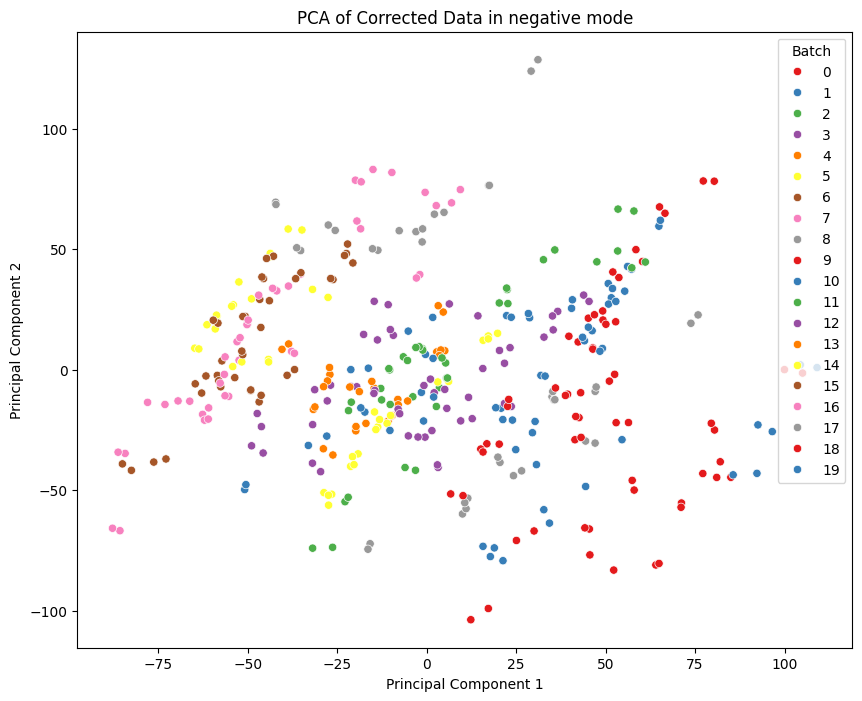

In [23]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

PCA = PCA(n_components=2)
corrected_df = np.log10(corrected_df)
X = corrected_df.T
X = StandardScaler().fit_transform(X)
pca_result = PCA.fit_transform(X)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Sample'] = df2.index
pca_df['Batch'] = df2['batch'].values
pca_df['Batch'] = pca_df['Batch'].astype('category')
pca_df['Sample'] = pca_df['Sample'].astype('category')
pca_df['Batch'] = pca_df['Batch'].cat.codes
pca_df['Sample'] = pca_df['Sample'].cat.codes

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Batch', palette='Set1')
plt.title('PCA of Corrected Data in negative mode')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Batch')
# plt.savefig('PCA_corrected_data.png', dpi=300)
plt.show()

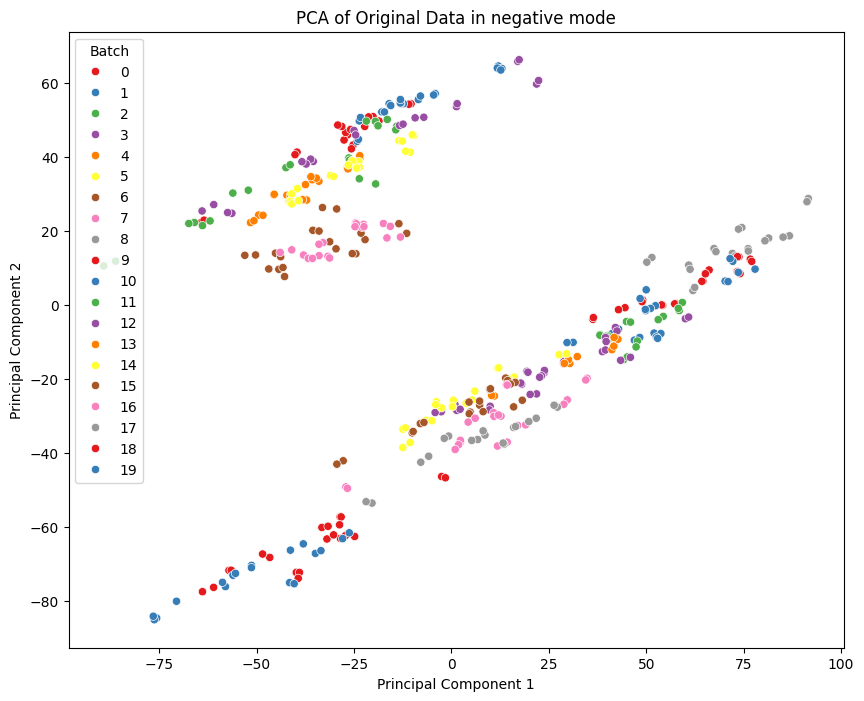

In [24]:
# orignial peak area for PCA 
rawpeak2 = loc2.copy()
# PCA analysis and plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
PCA = PCA(n_components=2)
X = rawpeak2.T
X = StandardScaler().fit_transform(X)
pca_result = PCA.fit_transform(X)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Sample'] = df2.index
pca_df['Batch'] = df2['batch'].values
pca_df['Batch'] = pca_df['Batch'].astype('category')
pca_df['Sample'] = pca_df['Sample'].astype('category')
pca_df['Batch'] = pca_df['Batch'].cat.codes
pca_df['Sample'] = pca_df['Sample'].cat.codes
# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Batch', palette='Set1')
plt.title('PCA of Original Data in negative mode')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Batch')
# plt.savefig('PCA_original_data.png', dpi=300)
plt.show()